# NMF Practical Work

**Umut Simsekli, Bertrand David, Paul Magron** 

Telecom Paris

In [12]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


/tmp/ipykernel_12123/1574094465.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  ms.use('seaborn-muted')


<Figure size 640x480 with 0 Axes>

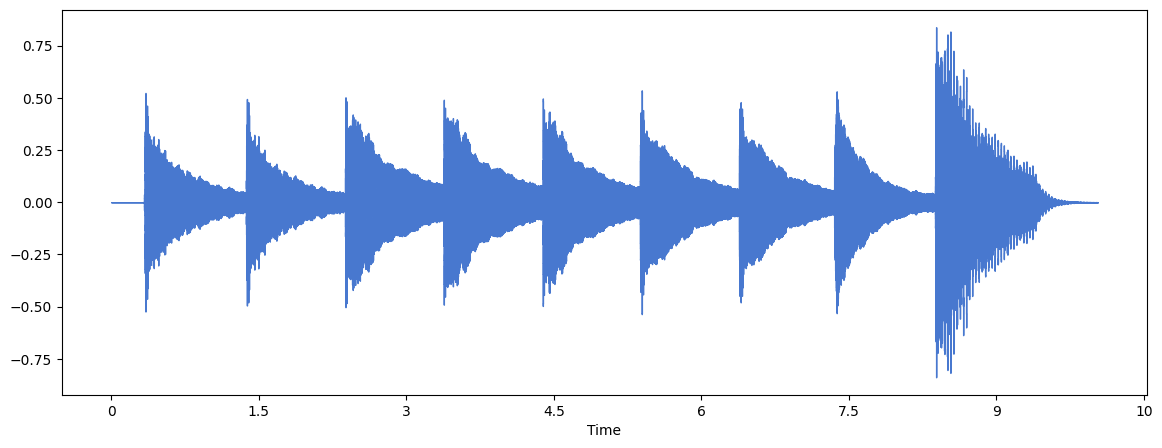

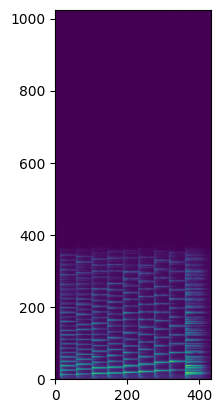

In [13]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [14]:
# Implement MUR for NMF with beta-divergence 



In [15]:
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


In [16]:
def build_signal(notes, Fs):
    """
%  Signal synthesis from piano isolated notes
%  
% 
% Inputs :
%     notes : matrix of notes with 4 lines : pitch, t onset, durations and
%     velocity
%     Fs : sample rate (in Hz)
%
% Outputs :
%     x : synthesis signal
    """
    pitch = notes[0, :]
    t_on = notes[1, :]
    durations = notes[2, :]
    vel = notes[3, :]
    Nnotes = len(pitch)
    Lsig = int((t_on[-1]+durations[-1])*Fs)
    x = np.zeros(Lsig)
    for n in range(Nnotes):
        # Get midi index
        ind_pitch = pitch[n]
        Lnote = int(durations[n]*Fs)
        
        # Read piano note
        xt, sr = librosa.load('data/{}.wav'.format(str(int(ind_pitch))))
        xt = librosa.resample(xt, sr, Fs)
        xt = xt[:Lnote] * vel[n]
        
        # Fill the current melodic line
        deb = int(t_on[n]*Fs)
        fin = deb + Lnote
        x[deb:fin] += xt
    return x

# Variantes autour d'un exemple simple

On synthétise d'abord un signal en générant les matrices d'activation et de base ${\bf W}$ et ${\bf H}$.

${\bf \underline{\text{Constantes du problème}}}$

In [17]:
FE = 8000
NFFT = 512
DO3 = 261.63
MI3 = 329.63
LA4 = 440


${\bf \underline{\text{Définition des fonctions}}}$

In [18]:
def spectre_harmonique(f0, NFFT, window, FE):
    freq_reduite = np.linspace(0, 1, NFFT)
    f0_reduite = f0 / FE
    indice_f0 = int(f0_reduite * NFFT)
    spectre = np.zeros(NFFT, dtype=np.complex_)
    semi_len_window = len(window) // 2
    # Rang max des harmoniques Kr*f0 < FE/2
    Kr = np.floor(1 / (2 * f0_reduite)).astype("int")
    for k in range(Kr):
        indice_f_centre = (k + 1) * indice_f0
        debut, fin = (
            indice_f_centre - semi_len_window,
            indice_f_centre + semi_len_window + 1,
        )
        spectre[debut:fin] += np.exp(-k / Kr) * window
    spectre[NFFT // 2 :] = np.flip(spectre[: NFFT // 2])
    return freq_reduite, spectre


# La "matrice MIDI" représente les activation sous forme de 0 et de 1
def activation(delta_T, tau_decroissance, matrice_midi, FE):
    n_points = int(matrice_midi.shape[1] * delta_T * FE)
    n_notes = matrice_midi.shape[0]
    h_activation = np.zeros((n_notes, n_points))
    decroissance_exp = np.exp(-np.arange(0, delta_T, 1 / FE) / tau_decroissance)
    indices_delta_T = len(decroissance_exp)
    for k, br in enumerate(matrice_midi.T):
        debut = k * indices_delta_T
        for note in range(n_notes):
            h_activation[note, debut : debut + indices_delta_T] = (
                br[note] * decroissance_exp
            )
    return h_activation


def mise_a_jour_W(W, H, X, beta):
    X_tilde = W @ H
    return (
        W
        * ((X * np.power(X_tilde, beta - 2)) @ H.T)
        / (np.power(X_tilde, beta - 1) @ H.T)
    )


def mise_a_jour_H(W, H, X, beta):
    X_tilde = W @ H
    return (
        H
        * (W.T @ (X * np.power(X_tilde, beta - 2)))
        / (W.T @ np.power(X_tilde, beta - 1))
    )


def mise_a_jour_globale(W, H, X, beta):
    W = mise_a_jour_W(W, H, X, beta)
    H = mise_a_jour_H(W, H, X, beta)
    return W, H, W @ H


def beta_div(X, X_tilde, beta):
    if beta ==2:
        return np.sum(
            np.power(X, beta) / (beta * (beta - 1))
            - X * np.power(X_tilde, beta - 1) / (beta - 1)
            + np.power(X_tilde, beta) / beta
        )
    elif beta == 1:
        return np.sum(X*np.log(X/X_tilde) - X + X_tilde)
    elif beta == 0:
        temp = X_tilde/X
        return np.sum(np.log(temp) + temp -1)
    else:
        print("Beta non pris en compte")
        return

${\bf \underline{\text{Calcul}}}$
On cherche la largeur de la fenêtre. On a une fréquence d'échantillonnage de 8000 Hz et on cherche une fenêtre de largeur 80 Hz.
\begin{align*}
    8000 &\Leftrightarrow NFFT\\
    80 &\Leftrightarrow \frac{NFFT}{100} \simeq 5 \\
\end{align*}

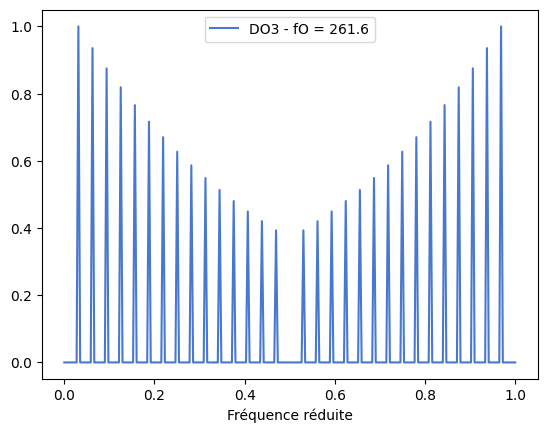

In [19]:
# Calcul de la largeur de fenêtre
largeur_fenetre_frequence = 80
len_window = NFFT*largeur_fenetre_frequence//FE
window_spectre = np.hanning(len_window)
freq_reduite, spectre_do = spectre_harmonique(DO3, NFFT, window_spectre, FE)

plt.plot(freq_reduite, np.abs(spectre_do), label=f"DO3 - fO = {DO3:.1f}")
plt.xlabel("Fréquence réduite")
plt.legend()
plt.show()

La matrice spectrale est la concaténation du spectre de chaque note. Chaque spectre est une colonne de la matrice de base spectrale.

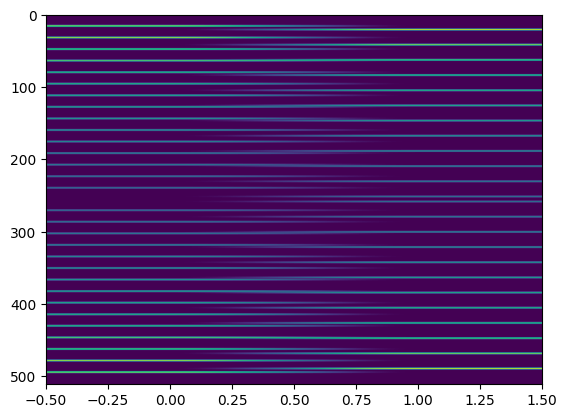

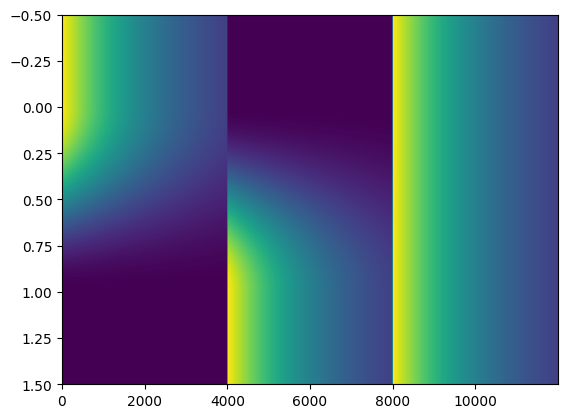

In [20]:
freq_reduite, spectre_mi = spectre_harmonique(MI3, NFFT, window_spectre, FE)
WS = np.concatenate([spectre_do.reshape(NFFT,1), spectre_mi.reshape(NFFT,1)], axis = 1)
plt.imshow(np.abs(WS))
plt.axis('auto')
plt.show()

# Matrice d'activation pour DO, MI, DO/MI
matrice_MIDI = np.array([[1, 0, 1],[0, 1, 1]])
H = activation(0.5, 0.3, matrice_MIDI, FE)

plt.imshow(H)
plt.axis('auto')
plt.show()

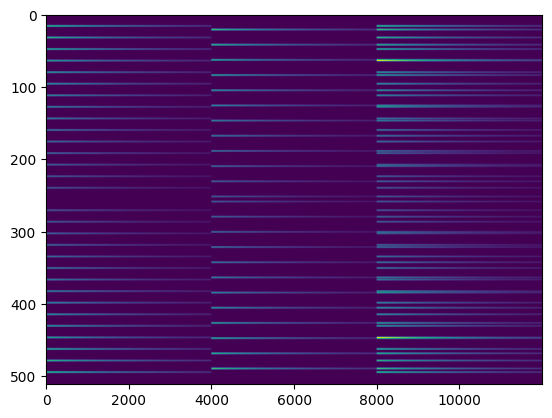

In [21]:
synthese = WS @ H

plt.imshow(np.abs(synthese))
plt.axis('auto')
plt.show()

Tracé de la fonction coùt au fil des ittérations. On initialise les matrices ${\bf W}$ et ${\bf H}$ avec du bruit blanc positif.

/tmp/ipykernel_12123/696200962.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  loss[k] = beta_div(synthese, Xtilde, beta)
/tmp/ipykernel_12123/952956923.py:39: RuntimeWarning: invalid value encountered in divide
  W
/tmp/ipykernel_12123/952956923.py:48: RuntimeWarning: invalid value encountered in divide
  H


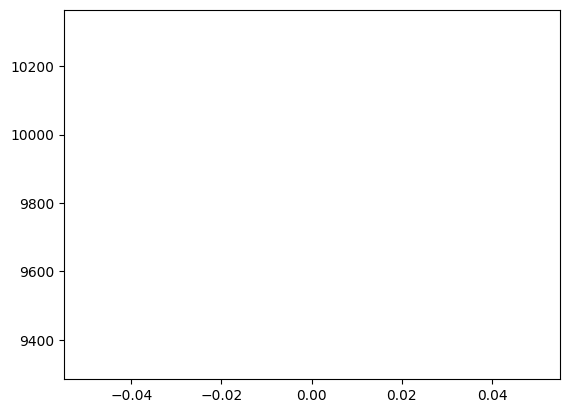

In [22]:
# On cherche à décomposer la matrice de synthese calculée précédement en matrices positives
n_note = 2
# Initialisation de W et H
W = np.random.rand(synthese.shape[0], n_note)+1
H = np.random.rand(n_note, synthese.shape[1])+1

beta = 2
loss = np.zeros(20)
for k in range(20):
    W, H, Xtilde = mise_a_jour_globale(W, H, synthese, beta)
    loss[k] = beta_div(synthese, Xtilde, beta)
plt.plot(loss)
plt.show()